# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch.nn as nn
import numpy as np 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch
#get the data from the directories 
train_path = '/data/landmark_images/train/'
test_path  = '/data/landmark_images/test/'

# convert data to a normalized torch.FloatTensor and resize them
transforming_data = transforms.Compose([transforms.Resize(32),transforms.CenterCrop(32),transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#loading the data using datasets ImageFolder 
train_data = datasets.ImageFolder(train_path , transform=transforming_data)
test_data  = datasets.ImageFolder(test_path , transform=transforming_data)

# obtain training indices that will be used for validation
valid_size=0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
batch_size = 55
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

print(len(train_idx),"  ", len(valid_idx), " " ,len(test_data))

3997    999   1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: depending on the code above, the code shows that i applied what i have learned from lessons starting from getting the data from the directories,converting,normalizing them also loading the images and defining the indices which used for validation and make samplers ,finally preparing the data loaders </br>

the most images belongs to landscape so i resized them to 32 as they are taken using a camera also i see there is no to do image augmentation so we won't make rotation or translation ,etc. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [2]:
#Specify the image classes
Classes=[]
for item in train_data.classes:
    Classes.append(item.replace(item[0:3]," "))
print(Classes)

[' Haleakala_National_Park', ' Mount_Rainier_National_Park', ' Ljubljana_Castle', ' Dead_Sea', ' Wroclaws_Dwarves', ' London_Olympic_Stadium', ' Niagara_Falls', ' Stonehenge', ' Grand_Canyon', ' Golden_Gate_Bridge', ' Edinburgh_Castle', ' Mount_Rushmore_National_Memorial', ' Kantanagar_Temple', ' Yellowstone_National_Park', ' Terminal_Tower', ' Central_Park', ' Eiffel_Tower', ' Changdeokgung', ' Delicate_Arch', ' Vienna_City_Hall', ' Matterhorn', ' Taj_Mahal', ' Moscow_Raceway', ' Externsteine', ' Soreq_Cave', ' Banff_National_Park', ' Pont_du_Gard', ' Seattle_Japanese_Garden', ' Sydney_Harbour_Bridge', ' Petronas_Towers', ' Brooklyn_Bridge', ' Washington_Monument', ' Hanging_Temple', ' Sydney_Opera_House', ' Great_Barrier_Reef', ' Monumento_a_la_Revolucion', ' Badlands_National_Park', ' Atomium', ' Forth_Bridge', ' Gateway_of_India', ' Stockholm_City_Hall', ' Machu_Picchu', ' Death_Valley_National_Park', ' Gullfoss_Falls', ' Trevi_Fountain', ' Temple_of_Heaven', ' Great_Wall_of_China'

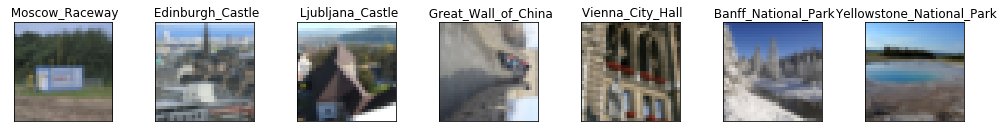

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


## TODO: visualize a batch of the train data loader
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(7):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(Classes[labels[idx]])
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)




### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer=optim.Adam(model.parameters(),lr=0.003)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        #convolutional Layers
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        #max pooling layer
        self.pool=nn.MaxPool2d(2,2)
        
        self.fc1=nn.Linear(64*4*4,500)
        self.fc2=nn.Linear(500,50)
        self.droupout=nn.Dropout(0.25)
        
         
        
    
    def forward(self, x):
        ## Define forward behavior
        #sequence of convolutional layers 
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        ##Flatten the input 
        x=x.view(-1,64*4*4)
        x=self.droupout(x)
        x=F.relu(self.fc1(x))
        x=self.droupout(x)
        x=self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (droupout): Dropout(p=0.25)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ First of all i started my code depending on the code which i have learned from lectures 
i started my code by defining my convolutional layers in the init function. i defined three conv layers starting from the depth of images ending with  64 in depth , also i used the most common ConVNet architecture 
INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC  >>> from here https://cs231n.github.io/convolutional-networks/#layers

also i added a droupout layer to prevent overfitting and finally added the final layers to match classes 


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            #clear the gradients of all optimized variables 
            optimizer.zero_grad()
            #pass the input data to the output to be predicted 
            output=model(data)
            #calculating the patch loss 
            loss = criterion(output,target)
            #compute gradients of loss using backward process 
            loss.backward()
            #perform optimization step 
            optimizer.step()
            #update loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 

            output=model(data)
            loss=criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss        

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [109]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    # takes in a module and applies the specified weight initialization
    classname=m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a centered, uniform distribution to the weights and bias zero 
        m.weight.data.uniform_(-0.5,0.5)
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(5, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 4.079167 	Validation Loss: 3.912631
Validation loss decreased (inf --> 3.912631).  Saving model ...
Epoch: 2 	Training Loss: 3.854748 	Validation Loss: 3.792297
Validation loss decreased (3.912631 --> 3.792297).  Saving model ...
Epoch: 3 	Training Loss: 3.770573 	Validation Loss: 3.719904
Validation loss decreased (3.792297 --> 3.719904).  Saving model ...
Epoch: 4 	Training Loss: 3.666123 	Validation Loss: 3.602335
Validation loss decreased (3.719904 --> 3.602335).  Saving model ...
Epoch: 5 	Training Loss: 3.543626 	Validation Loss: 3.468980
Validation loss decreased (3.602335 --> 3.468980).  Saving model ...


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [110]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.840508 	Validation Loss: 3.741092
Validation loss decreased (inf --> 3.741092).  Saving model ...
Epoch: 2 	Training Loss: 3.719813 	Validation Loss: 3.682661
Validation loss decreased (3.741092 --> 3.682661).  Saving model ...
Epoch: 3 	Training Loss: 3.591060 	Validation Loss: 3.583488
Validation loss decreased (3.682661 --> 3.583488).  Saving model ...
Epoch: 4 	Training Loss: 3.441590 	Validation Loss: 3.483510
Validation loss decreased (3.583488 --> 3.483510).  Saving model ...
Epoch: 5 	Training Loss: 3.284102 	Validation Loss: 3.300262
Validation loss decreased (3.483510 --> 3.300262).  Saving model ...
Epoch: 6 	Training Loss: 3.142119 	Validation Loss: 3.226332
Validation loss decreased (3.300262 --> 3.226332).  Saving model ...
Epoch: 7 	Training Loss: 3.007743 	Validation Loss: 3.143485
Validation loss decreased (3.226332 --> 3.143485).  Saving model ...
Epoch: 8 	Training Loss: 2.878742 	Validation Loss: 3.100279
Validation loss decreased (3.14348

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.996612


Test Accuracy: 25% (324/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [8]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
##this is a copy of the above code when i created CNN from scratch 
#get the data from the directories 
train_path = '/data/landmark_images/train/'
test_path  = '/data/landmark_images/test/'

# convert data to a normalized torch.FloatTensor and resize them to be 224
transforming_data = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#loading the data using datasets ImageFolder 
train_data = datasets.ImageFolder(train_path , transform=transforming_data)
test_data  = datasets.ImageFolder(test_path , transform=transforming_data)

# obtain training indices that will be used for validation
valid_size=0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
batch_size = 55
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

print(len(train_idx),"  ", len(valid_idx), " " ,len(test_data))



3997    999   1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [9]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    #we will optimize the parameters of the classifier only , the others will be frozen
    optimizer=torch.optim.SGD(model.classifier.parameters(),lr=0.003)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
## TODO: Specify model architecture
# Load the pretrained model from pytorch
from torchvision import models
model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

## TODO: add a last linear layer  that maps n_inputs -> 50 landscape classes
## new layers automatically have requires_grad = True
n_input = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_input,len(Classes))
model_transfer.classifier[6]=last_layer


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 78808979.36it/s] 


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  first of all , i took the vgg16 pretrained model as explained in the lectures <br>
I frozen the parameters of the vgg16 model only i changed the parameters of the last layer to match the classes of my data.<br>
i modified the last layer and make , and kept the number of inputs but changed the number of outputs to match our classes<br>
also i follow this link https://cs231n.github.io/convolutional-networks/#layers <br>
in the last i passed the last layer which i have created to the model 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [11]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs=8
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.548498 	Validation Loss: 3.044671
Validation loss decreased (inf --> 3.044671).  Saving model ...
Epoch: 2 	Training Loss: 2.746149 	Validation Loss: 2.385153
Validation loss decreased (3.044671 --> 2.385153).  Saving model ...
Epoch: 3 	Training Loss: 2.190948 	Validation Loss: 1.904992
Validation loss decreased (2.385153 --> 1.904992).  Saving model ...
Epoch: 4 	Training Loss: 1.811134 	Validation Loss: 1.634332
Validation loss decreased (1.904992 --> 1.634332).  Saving model ...
Epoch: 5 	Training Loss: 1.602550 	Validation Loss: 1.483451
Validation loss decreased (1.634332 --> 1.483451).  Saving model ...
Epoch: 6 	Training Loss: 1.451214 	Validation Loss: 1.377588
Validation loss decreased (1.483451 --> 1.377588).  Saving model ...
Epoch: 7 	Training Loss: 1.335381 	Validation Loss: 1.294413
Validation loss decreased (1.377588 --> 1.294413).  Saving model ...
Epoch: 8 	Training Loss: 1.260156 	Validation Loss: 1.253051
Validation loss decreased (1.29441

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [14]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.172410


Test Accuracy: 69% (874/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [15]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    # set the module to evaluation mode
    model_transfer.eval()
    image_pred=transforming_data(Image.open(img_path))
    image_pred.unsqueeze_(0)
    
    if use_cuda:
        image_pred=image_pred.cuda()
    output_prediction = model_transfer(image_pred)
    _,top_predictions = torch.topk(output_prediction,k)
    
        
    prediction_indx =np.squeeze(top_predictions.cpu().numpy())
    predicted_classes=[]
    for prediction in prediction_indx:
        predicted_classes.append(Classes[prediction])
    
    return predicted_classes

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

[' Golden_Gate_Bridge',
 ' Forth_Bridge',
 ' Brooklyn_Bridge',
 ' Sydney_Harbour_Bridge',
 ' Eiffel_Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the 
   Golden_Gate_Bridge ,  Forth_Bridge ,  Brooklyn_Bridge ?


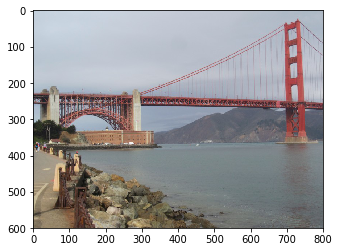

In [16]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    image = Image.open(img_path)
    plt.imshow(image)
    print('Is this picture of the \n ',predicted_landmarks[0] ,',',predicted_landmarks[1],',',predicted_landmarks[2],'?')

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ it is fairly good </br>
to improve it i can do some steps:</br>
1- provide additional images for the model to train on </br>
2- adding mor layers to the network </br>
3- change the optimizer function</br>
4- add some complex liner layers</br>

Is this picture of the 
   Badlands_National_Park ,  Delicate_Arch ,  Machu_Picchu ?


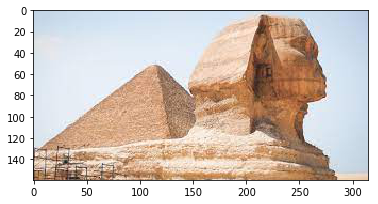

In [17]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('predict_sample/download.jpeg')

Is this picture of the 
   Monumento_a_la_Revolucion ,  Kantanagar_Temple ,  Vienna_City_Hall ?


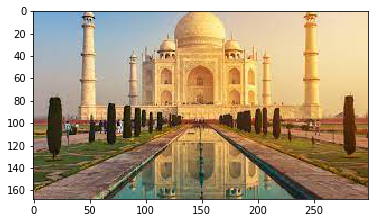

In [18]:
suggest_locations('predict_sample/download (1).jpeg')

Is this picture of the 
   Sydney_Harbour_Bridge ,  Vienna_City_Hall ,  Monumento_a_la_Revolucion ?


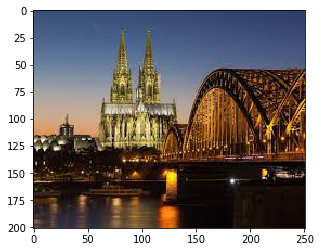

In [19]:
suggest_locations('predict_sample/images (1).jpeg')

Is this picture of the 
   Gateway_of_India ,  Kantanagar_Temple ,  Temple_of_Olympian_Zeus ?


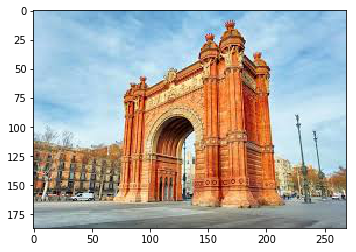

In [20]:
suggest_locations('predict_sample/images (2).jpeg')

Is this picture of the 
   Eiffel_Tower ,  Gateway_of_India ,  Monumento_a_la_Revolucion ?


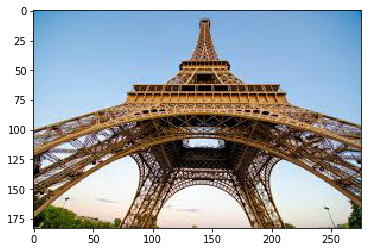

In [21]:
suggest_locations('predict_sample/images.jpeg')